Output()

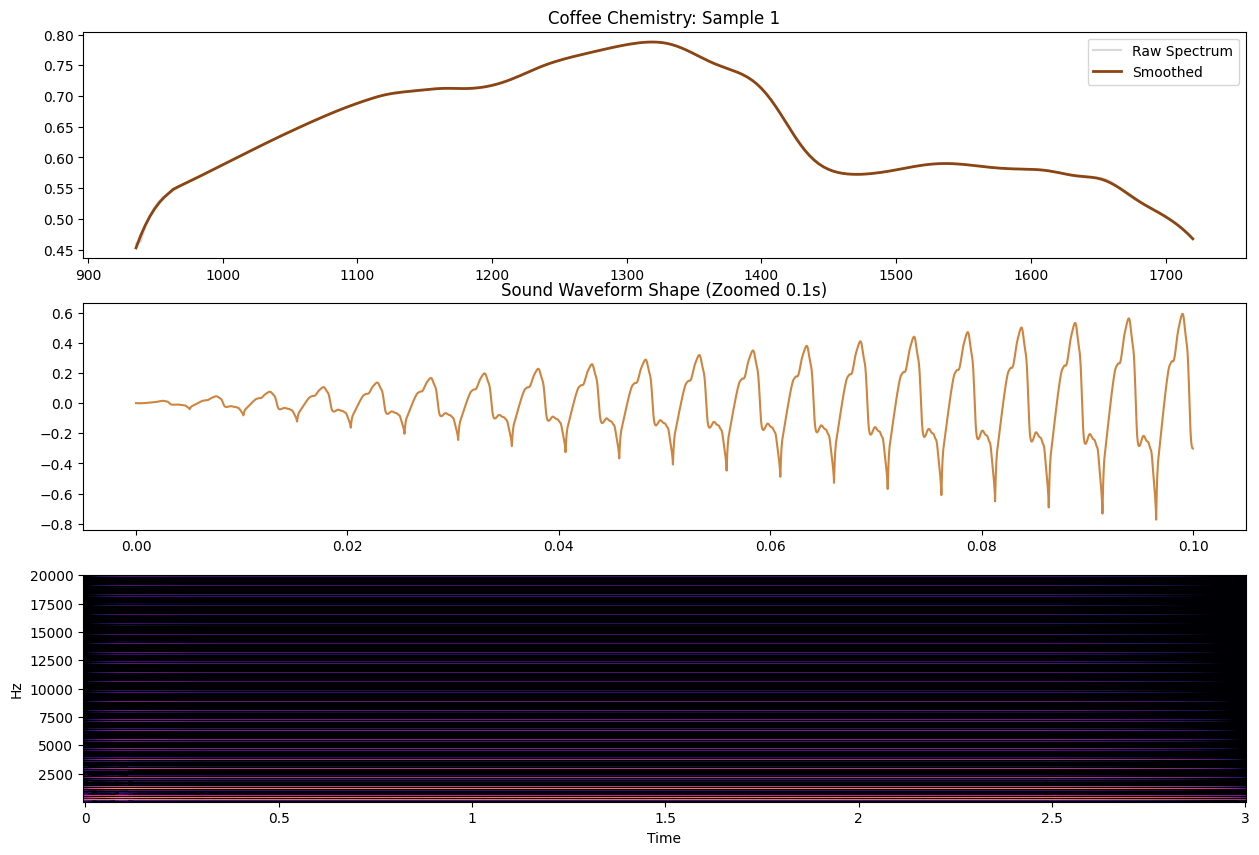

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import soundfile as sf
from scipy.signal import savgol_filter
from IPython.display import Audio, display
import ipywidgets as widgets

# Load Data (Done once)
df = pd.read_csv('Instant_Coffee_Test_Samples.csv')
sample_options = [(f"ID: {row['Sample_ID']} (Row {idx})", idx) for idx, row in df.iterrows()]

# ADSR Function
def create_adsr_envelope(duration, sr, a, d, s, r):
    total_samples = int(duration * sr)
    a_samples = int(a * sr)
    d_samples = int(d * sr)
    r_samples = int(r * sr)
    s_samples = total_samples - (a_samples + d_samples + r_samples)
    
    if s_samples < 0:
        return np.zeros(total_samples) # Safety check

    envelope = np.concatenate([
        np.linspace(0, 1, a_samples),
        np.linspace(1, s, d_samples),
        np.full(s_samples, s),
        np.linspace(s, 0, r_samples)
    ])
    return envelope

# Create UI Widgets
style = {'description_width': 'initial'}

sample_dropdown = widgets.Dropdown(options=sample_options, description="Coffee Sample:", style=style)
stretch_slider = widgets.FloatSlider(value=1.0, min=0.2, max=4.0, step=0.01, description="Pitch Shift", style=style)
pitch_label = widgets.Label(value="Note: -- | Offset: 0.0", layout=widgets.Layout(margin='0 0 0 20px'))

volume_slider = widgets.FloatSlider(value=0.8, min=0, max=1.0, step=0.1, description="Master Volume", style=style)
attack_slider = widgets.FloatSlider(value=0.1, min=0.01, max=0.5, description="Attack")
decay_slider = widgets.FloatSlider(value=0.2, min=0.01, max=0.5, description="Decay")
sustain_slider = widgets.FloatSlider(value=0.7, min=0.1, max=1.0, step=0.1, description="Sustain")
release_slider = widgets.FloatSlider(value=0.5, min=0.1, max=1.0, step=0.1, description="Release")
smooth_slider = widgets.IntSlider(value=15, min=5, max=51, step=2, description="Smoothness", style=style)

# Main Processing Function
def sonify_coffee(row_index, attack, decay, sustain, release, volume, window_len, pitch_shift):
    # Data extraction
    sample_id = df.iloc[row_index, 0]
    raw_values = df.iloc[row_index, 1:].values.astype(float)
    wavelengths = df.columns[1:].str.replace('X', '').astype(float)
    
    # Audio Params
    duration = 3.0
    sr = 44100
    
    # Processing
    smoothed = savgol_filter(raw_values, window_length=window_len, polyorder=3)
    base_cycle = librosa.util.normalize(smoothed - np.mean(smoothed))
    
    # Stretch
    new_cycle_len = int(len(base_cycle) * pitch_shift)
    audio_signal = librosa.resample(base_cycle, orig_sr=len(base_cycle), target_sr=new_cycle_len)

    # Loop and Envelope
    num_samples = int(sr * duration)
    full_audio = np.tile(audio_signal, int(np.ceil(num_samples / len(audio_signal))))[:num_samples]
    envelope = create_adsr_envelope(duration, sr, attack, decay, sustain, release)
    
    # Final Signal
    final_audio = full_audio * envelope * volume
    
    # Pitch detection
    f0_values = librosa.yin(final_audio, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
    avg_f0 = np.nanmean(f0_values)
    detected_note = librosa.hz_to_note(avg_f0) if not np.isnan(avg_f0) else "Unknown"
    semitone_offset = -12 * np.log2(pitch_shift)
    # Update the UI Label next to the slider
    pitch_label.value = f"🎵 {detected_note} ({avg_f0:.1f} Hz) | Offset: {semitone_offset:+.1f} semitones"

# Visualization
    plt.figure(figsize=(15, 10))
    
    # Spectrum Plot
    plt.subplot(3, 1, 1)
    plt.plot(wavelengths, raw_values, label="Raw Spectrum", alpha=0.3, color='gray')
    plt.plot(wavelengths, smoothed, label="Smoothed", color='saddlebrown', linewidth=2)
    plt.title(f"Coffee Chemistry: Sample {sample_id}")
    plt.legend()

    # Waveform Plot
    plt.subplot(3, 1, 2)
    time_axis = np.linspace(0, duration, len(final_audio))
    plt.plot(time_axis[:int(0.1*sr)], final_audio[:int(0.1*sr)], color='peru')
    plt.title("Sound Waveform Shape (Zoomed 0.1s)")

    # Spectrogram Plot
    plt.subplot(3, 1, 3)
    D = librosa.stft(final_audio, n_fft=4096, hop_length=512)
    S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
    img = librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='hz', cmap='magma', ax=plt.gca())
    plt.ylim(20, 20000)
    plt.colorbar(img, format="%+2.0f dB")
    plt.title("Audio Spectrogram (Harmonic Fingerprint)")
    
    plt.tight_layout()
    plt.show()
    
    # --- Audio Player ---
    display(Audio(final_audio, rate=sr, autoplay=False))

# UI layout
ui = widgets.VBox([
    widgets.HTML("<h2>☕ Coffee Sonification Lab</h2>"),
    sample_dropdown,
    widgets.HBox([stretch_slider, pitch_label]),
    widgets.HBox([volume_slider, smooth_slider]),
    widgets.HTML("<b>ADSR Envelope Settings:</b>"),
    widgets.HBox([attack_slider, decay_slider, sustain_slider, release_slider]),
])

# 5. Connect Logic to UI
out = widgets.interactive_output(sonify_coffee, {
    'row_index': sample_dropdown,
    'pitch_shift': stretch_slider,
    'volume': volume_slider,
    'attack': attack_slider,
    'decay': decay_slider,
    'sustain': sustain_slider,
    'release': release_slider,
    'window_len': smooth_slider
})

display(ui, out)